In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
%matplotlib inline

# 1. Detect center of the ball on 1 image

## Read and smooth an image

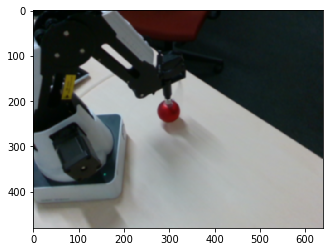

In [2]:
im = cv2.imread("images/color_0.png")
im = cv2.GaussianBlur(im, (7,7),0)
plt.imshow(im[:,:,::-1])

### Load Region of Interest

In [3]:
with open("configs/roi.json") as f:
    roi = json.load(f)
print(roi)
mask = np.zeros_like(im)
mask = cv2.rectangle(mask, (roi['x'], roi["y"]), (roi['x']+roi["width"], roi["y"]+roi["height"]), (255,255,255), -1)

{'x': 150, 'y': 150, 'height': 330, 'width': 390}


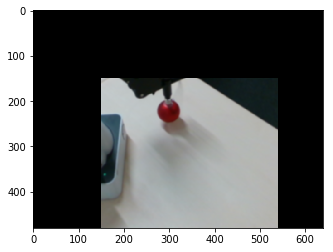

In [4]:
im = cv2.bitwise_and(mask, im)
plt.imshow(im[:,:,::-1])

### View hsv

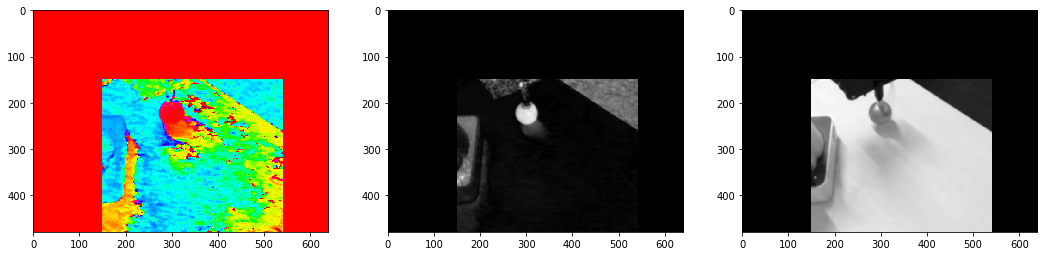

In [5]:
hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(18,9))
for i in range(3):
    plt.subplot(1,3,i+1)
    cmap = plt.cm.gray if i != 0 else plt.cm.hsv
    plt.imshow(hsv[:,:,i], cmap=cmap)

### Filter red ball

In [6]:
saturation = hsv[...,1]
saturation[(hsv[...,0] > 15) & (hsv[...,0] < 165)]=0

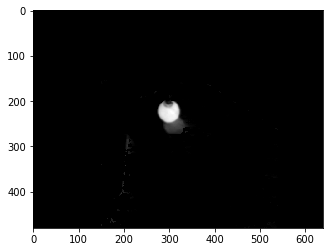

In [7]:
plt.imshow(saturation, cmap=plt.cm.gray)

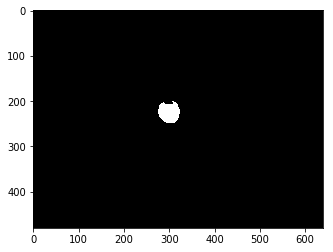

In [8]:
_, im1 = cv2.threshold(saturation, 92, 255, cv2.THRESH_BINARY)
plt.imshow(im1, cmap=plt.cm.gray)

## Find the largest object

In [9]:
#in different version of opencv return of findContours is different. 
#Please refer to the documentation for the right return values order
contours = cv2.findContours(im1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
contour = max(contours, key=cv2.contourArea)
b_rect = cv2.boundingRect(contour)
b_rect

(276, 201, 48, 48)

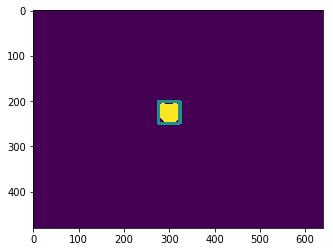

In [10]:
cv2.rectangle(im1, (b_rect[0], b_rect[1]), (b_rect[0]+b_rect[2], b_rect[1]+b_rect[3]), (128,0,0), 5)
plt.imshow(im1)

### Warp the code above into a function

In [11]:
def get_center(image, mask):
    """Return center of the largest red ball
    
    Keyword arguments:
    image -- numpy array image in BGR color space
    mask -- numpy array with region of interest. Should be the same shape as image. Use (255,255,255) for points in RoI and (0,0,0) for points outside
    """
    im = cv2.GaussianBlur(image, (7,7), 0)
    im = cv2.bitwise_and(mask, im)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    saturation = hsv[...,1]
    saturation[(hsv[...,0] > 15) & (hsv[...,0] < 165)] = 0
    _, im1 = cv2.threshold(saturation, 92, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(im1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    contour = max(contours, key=cv2.contourArea)
    b_rect = cv2.boundingRect(contour)
    return (b_rect[0]+b_rect[2]/2, b_rect[1]+b_rect[3]/2)

center = get_center(im, mask)
center

(300.0, 225.5)

### Transform from uv-depth coordinates to the xyz coordinates
for additional details refer to https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html


In [12]:
with open("configs/camera_matrix.json") as f:
    camera_matrix = json.load(f)
camera_matrix = np.array(camera_matrix)

def get_world_coords(x,y, depth, camera_matrix=camera_matrix):
    """return physical coordinates in mm
    
    Keyword arguments:
    x, y -- coordinates of a point in pixels
    depth -- depth coordiante of the same point
    camera_matrix -- 3x3 matrix with focal lengthes and principial point"""
    f = np.linalg.inv(camera_matrix)
    v = np.array([x,y,1]) * depth
    return np.dot(f,v)

# 2. Get coordinates for each calibration image

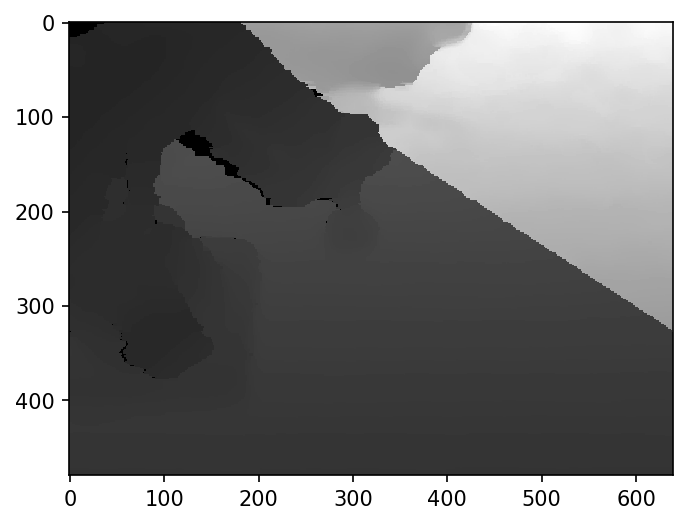

In [13]:
depth_image = cv2.imread("images/depth_0.png", cv2.IMREAD_UNCHANGED )
plt.figure(dpi=150)
plt.imshow(depth_image, cmap=plt.cm.gray)

In [14]:
def get_world_coords_n(n, mask=mask, base_path="images/"):
    """ return xyz coordinates of the largest red ball for an image and depth number n
    
    Keyword arguments:
    n -- number of image in the folder
    base_path -- path to the folder, conatining calibration images (default: images)
    """
    i0 = cv2.imread(os.path.join(base_path, "color_{}.png".format(n)))
    i1 = cv2.imread(os.path.join(base_path, "depth_{}.png".format(n)), cv2.IMREAD_UNCHANGED)
    center = get_center(i0, mask)
    depth = i1[int(center[1]), int(center[0])]
    return get_world_coords(center[0], center[1], depth)


### all xyz coordinates from camera

In [15]:
number_images = len(os.listdir("images")) //2
camera_coords = [get_world_coords_n(i) for i in range(number_images)]
camera_coords

[array([-26.74679771, -20.88916467, 575.        ]),
 array([-15.0833678 , 120.68425656, 451.        ]),
 array([ 80.49450886, 116.4339842 , 456.        ]),
 array([ 67.79186327, -27.23094029, 580.        ]),
 array([-28.43593506, -52.31547162, 536.        ]),
 array([-16.51183178,  87.90871212, 413.        ]),
 array([ 78.19175697,  83.78910426, 416.        ]),
 array([ 67.84363408, -59.65403373, 539.        ])]

### all xyz coordinates from a robot

In [16]:
with open("positions/positions.txt") as f:
    posiitons = json.load(f)["positions"]
posiitons

[{'x': 180, 'y': 100, 'z': -10},
 {'x': 180, 'y': -100, 'z': -10},
 {'x': 280, 'y': -100, 'z': -10},
 {'x': 280, 'y': 100, 'z': -10},
 {'x': 180, 'y': 100, 'z': 40},
 {'x': 180, 'y': -100, 'z': 40},
 {'x': 280, 'y': -100, 'z': 40},
 {'x': 280, 'y': 100, 'z': 40}]

In [17]:
robot_coords = np.zeros((len(posiitons), 3))
for i in range(len(posiitons)):
    robot_coords[i,0] = posiitons[i]["x"]
    robot_coords[i,1] = posiitons[i]["y"]
    robot_coords[i,2] = posiitons[i]["z"]
robot_coords

array([[ 180.,  100.,  -10.],
       [ 180., -100.,  -10.],
       [ 280., -100.,  -10.],
       [ 280.,  100.,  -10.],
       [ 180.,  100.,   40.],
       [ 180., -100.,   40.],
       [ 280., -100.,   40.],
       [ 280.,  100.,   40.]])

# 3. Compute calibration

## we need to make more perciese geometry, with respect to the ball radius

In [18]:
ball_radius = 24 #mm

### actual center of the ball is <i>ball_radius</i> further than the point we see on an image

In [19]:
for i in range(number_images):
    d = np.linalg.norm(camera_coords[i])
    camera_coords[i] = camera_coords[i]*(d+ball_radius)/d
camera_coords

[array([-27.86124636, -21.75954554, 598.95830631]),
 array([-15.85834506, 126.88496423, 474.17219529]),
 array([ 84.54060795, 122.28660004, 478.92108134]),
 array([ 70.57505192, -28.34890402, 603.81184617]),
 array([-29.70140129, -54.64363359, 559.85326512]),
 array([-17.44961564,  92.9014575 , 436.45619439]),
 array([ 82.54079673,  88.4494695 , 439.13799578]),
 array([ 70.82294313, -62.27370181, 562.66983432])]

### robot touches the ball 1 <i>ball_radius</i> upper than the real center

In [20]:
for i in range(number_images):
    robot_coords[i,2] = robot_coords[i,2] - ball_radius
robot_coords

array([[ 180.,  100.,  -34.],
       [ 180., -100.,  -34.],
       [ 280., -100.,  -34.],
       [ 280.,  100.,  -34.],
       [ 180.,  100.,   16.],
       [ 180., -100.,   16.],
       [ 280., -100.,   16.],
       [ 280.,  100.,   16.]])

In [21]:
camera_coords = np.array(camera_coords).astype(np.float32)
robot_coords = np.array(robot_coords).astype(np.float32)
camera_coords, robot_coords

(array([[-27.861246, -21.759546, 598.9583  ],
        [-15.858345, 126.884964, 474.17218 ],
        [ 84.54061 , 122.2866  , 478.92108 ],
        [ 70.57505 , -28.348904, 603.8118  ],
        [-29.7014  , -54.643635, 559.8533  ],
        [-17.449615,  92.90146 , 436.4562  ],
        [ 82.540794,  88.44947 , 439.138   ],
        [ 70.822945, -62.2737  , 562.66986 ]], dtype=float32),
 array([[ 180.,  100.,  -34.],
        [ 180., -100.,  -34.],
        [ 280., -100.,  -34.],
        [ 280.,  100.,  -34.],
        [ 180.,  100.,   16.],
        [ 180., -100.,   16.],
        [ 280., -100.,   16.],
        [ 280.,  100.,   16.]], dtype=float32))

In [22]:
trans = cv2.estimateAffine3D(camera_coords, robot_coords)[1]
trans

array([[ 1.00154934e+00, -6.31760959e-02,  2.79669077e-02,
         1.90637882e+02],
       [-7.73972176e-02, -7.89589772e-01,  6.48864998e-01,
        -3.08714053e+02],
       [-4.74842857e-03, -6.29188538e-01, -7.50240753e-01,
         4.01502556e+02]])

### if everything is correct, determinant should be close to 1

In [23]:
np.linalg.det(trans[:,:3])

1.0073113072557371

In [24]:
print(trans)

[[ 1.00154934e+00 -6.31760959e-02  2.79669077e-02  1.90637882e+02]
 [-7.73972176e-02 -7.89589772e-01  6.48864998e-01 -3.08714053e+02]
 [-4.74842857e-03 -6.29188538e-01 -7.50240753e-01  4.01502556e+02]]
